In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
repo=os.environ['LYA_EMU_REPO']
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
set_k=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=0,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=set_k.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

In [5]:
## Now want to train an emulator on all 200 sims, and use those hyperparameters and
## param scalings to use 199 points and predict the 1 remaining
full_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
kfs=full_archive.get_param_values("kF_Mpc")

In [9]:
print(np.argmin(kfs))

1191


In [10]:
print(full_archive.data[1191]["z"])

2.0


In [11]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,set_noise_var=1e-3,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1600 points
Optimised


In [12]:
emu_lowk=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,kmax_Mpc=1,
                                verbose=False,paramList=paramList,train=True,set_noise_var=1e-3,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

Training GP on 1600 points
Optimised


In [18]:
def return_crossvals(hyperparams):
    """ Pass a GP emulator, this will return arrays of the fractional
    true and theoretical error. This function will include values
    on or outside the convex hull """
    
    if len(hyperparams)==3:
        rbf_only=True
    elif len(hyperparams)==4:
        rbf_only=False
    else:
        print("Wrong number of hyperparams:" , len(hyperparams))
    
    ## Data arrays
    fractional_error=np.empty((200,8,len(k_test)))
    theory_error=np.empty((200,8,len(k_test)))
    
    iterable_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


    for simnum in range(0,200):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        
        ## Temporarily remove the first 8 items, corresponding to this sim
        temp_list=[]
        for aa in range(0,8):
            temp_list.append(iterable_archive.data.pop(0))
                            
        
        emu_test=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=iterable_archive,
                                drop_tau_rescalings=True,checkHulls=True,
                                drop_temp_rescalings=True,rbf_only=rbf_only)
        emu_test.load_hyperparams(hyperparams)
        emu_test.crossval=True
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(paramList):
                emu_call[param]=item[param]

            print("Making emu call")
            pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])

            fractional_error[simnum,aa,:]=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
            #theory_error[simnum,aa,:]=(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)]
            theory_error[simnum,aa,:]=(np.sqrt(np.diag(err)))/pred
                             
        ## Now rebuild the archive, put the old sim at the end
        for item in temp_list:
            iterable_archive.data.append(item)
            
    return np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0),np.mean(theory_error,axis=0),np.std(theory_error,axis=0)

In [21]:
def return_crossvals_nohull(hyperparams):
    """ Pass a GP emulator, this will return arrays of the fractional
    true and theoretical error. This function will only include emulator calls made
    within the convex hull """
    
    if len(hyperparams)==3:
        rbf_only=True
    elif len(hyperparams)==4:
        rbf_only=False
    else:
        print("Wrong number of hyperparams:" , len(hyperparams))
    
    ## New crossval loop
    fractional_error=[]
    theory_error=[]
    cross_val=[]
    distances=[]
    for aa in range(0,8):
        fractional_error.append([])
        theory_error.append([])
        cross_val.append([])
        for bb in range(len(k_test)):
            fractional_error[aa].append([])
            theory_error[aa].append([])
            cross_val[aa].append([])
    
    iterable_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


    for simnum in range(0,200):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        
        ## Temporarily remove the first 8 items, corresponding to this sim
        temp_list=[]
        for aa in range(0,8):
            temp_list.append(iterable_archive.data.pop(0))
                            
        
        emu_test=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=iterable_archive,
                                drop_tau_rescalings=True,checkHulls=True,
                                drop_temp_rescalings=True,rbf_only=rbf_only)
        emu_test.load_hyperparams(hyperparams)
        emu_test.crossval=True
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(paramList):
                emu_call[param]=item[param]

            #print("Making emu call")
            try:
                ## Try make emulator call
                pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
                true=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
                theory=(np.sqrt(np.diag(err)))/pred
                cv=(pred-item["p1d_Mpc"][1:(len(k_test)+1)])/np.sqrt(np.diag(err))
                distances.append(emu_test.get_nearest_distance(emu_call))
                for bb in range(len(pred)):
                    fractional_error[aa][bb].append(true[bb])
                    theory_error[aa][bb].append(theory[bb])
                    cross_val[aa][bb].append(cv[bb])
                
            except:
                ## Skip this redshift as this emulator call is outside
                ## convex hull
                continue
                             
        ## Now rebuild the archive, put the old sim at the end
        for item in temp_list:
            iterable_archive.data.append(item)
        
    true_mean=np.empty((8,len(k_test)))
    true_std=np.empty((8,len(k_test)))
    theory_mean=np.empty((8,len(k_test)))
    theory_std=np.empty((8,len(k_test)))
    for aa in range(8):
        for bb in range(len(k_test)):
            true_data=np.asarray(fractional_error[aa][bb])
            true_mean[aa][bb]=np.mean(true_data)
            true_std[aa][bb]=np.std(true_data)
            theory_data=np.asarray(theory_error[aa][bb])
            theory_mean[aa][bb]=np.mean(theory_data)
            theory_std[aa][bb]=np.std(theory_data)
    
    ## Now get means and std deviations
    return true_mean, true_std, theory_mean, theory_std, cross_val, distances

In [22]:
mean_fractional,std_fractional,mean_theory,std_theory,cv,dist=return_crossvals_nohull(emu_lowk.gp.param_array)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [ ]:
mean_fractional_all,std_fractional_all,mean_theory_all,std_theory_all,cv_all,dist_all=return_crossvals_nohull(emu.gp.param_array)

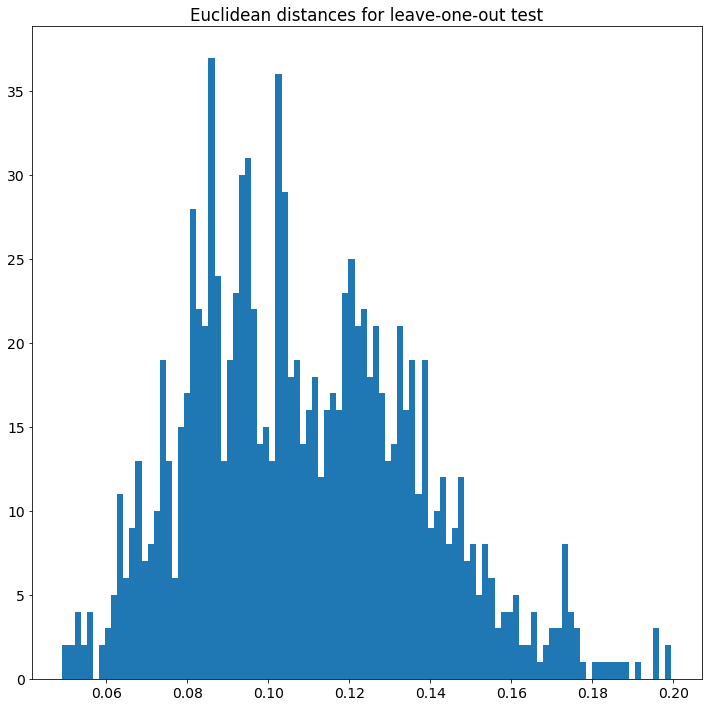

In [25]:
plt.figure(figsize=(12,12))
_=plt.hist(dist,bins=100)
plt.title("Euclidean distances for leave-one-out test")
plt.savefig("distance_leave_one_out.pdf")

In [29]:
theoryerr_flat=[]
for sublist in mean_theory:
    for item in sublist:
        theoryerr_flat.append(item)

(0, 0.5)

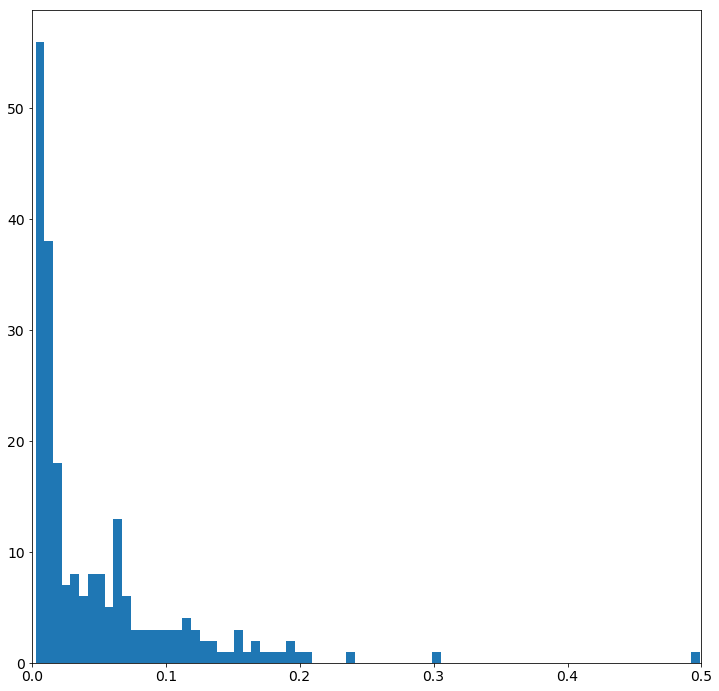

In [32]:
plt.figure(figsize=(12,12))
_=plt.hist(theoryerr_flat,bins=500)
plt.xlim(0,0.5)

In [34]:
print(theoryerr_flat)

[0.007294788645427544, 0.007428750197140146, 0.00709140330592639, 0.007202987107293378, 0.006920828711190764, 0.0063753902036903605, 0.006370658622478884, 0.005993258360051758, 0.006016381454112678, 0.005794700350546331, 0.005803617383929835, 0.0055222895183053506, 0.005473719885187345, 0.005310190873909804, 0.005297498248411342, 0.0052320003741763614, 0.005105434654178552, 0.00503476602379004, 0.004980463422562834, 0.004879080684364292, 0.004947736647540756, 0.004847762920214023, 0.004751949550897133, 0.00469195860812222, 0.004683615316487525, 0.0046042453614699615, 0.004521400400202525, 0.0044707778221342994, 0.009150641806422322, 0.009300302685114182, 0.009033193072577867, 0.009097666379942252, 0.008883746068441648, 0.008369610251453342, 0.00833198655124193, 0.008025763940076484, 0.00811659597418998, 0.007952950694888128, 0.00807105827386089, 0.007875752581070712, 0.007909480595468274, 0.007814231321538074, 0.007916974903377177, 0.007947444433228637, 0.007921574648961838, 0.00788068

In [ ]:
def return_crossvals_z():
    """ Cross validation for z and k for a redshift-split
    emulator """
    
    ## Data arrays
    fractional_error=np.empty((200,8,len(k_test)))
    theory_error=np.empty((200,8,len(k_test)))
    
    iterable_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


    for simnum in range(0,200):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        
        ## Temporarily remove the first 8 items, corresponding to this sim
        temp_list=[]
        for aa in range(0,8):
            temp_list.append(iterable_archive.data.pop(0))
                            
        
        emu_test=z_emulator.ZEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=iterable_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(paramList):
                emu_call[param]=item[param]

            pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])

            fractional_error[simnum,aa,:]=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
            theory_error[simnum,aa,:]=(pred+np.sqrt(np.diag(err)))/pred
                             
        ## Now rebuild the archive, put the old sim at the end
        for item in temp_list:
            iterable_archive.data.append(item)
            
    return np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0),np.mean(theory_error,axis=0),np.std(theory_error,axis=0)

In [ ]:
mean_fractional,std_fractional,mean_theory,std_theory=return_crossvals(emu.gp.param_array)

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted/truth). Optimised on low k only in solid")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_fractional[aa,:]+std_fractional[aa,:],
            mean_fractional[aa,:]-std_fractional[aa,:],alpha=0.5,color=col)
    plt.plot(k_test,mean_fractional_all[aa,:],color=col,linestyle="dashed")
    plt.fill_between(k_test,mean_fractional_all[aa,:]+std_fractional_all[aa,:],
            mean_fractional_all[aa,:]-std_fractional_all[aa,:],alpha=0.5,color=col)
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
#plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_true_error_comparison.pdf")

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error. Optimised on low k only in solid")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory[aa,:]+std_theory[aa,:]-1,
            mean_theory[aa,:]-std_theory[aa,:]-1,alpha=0.5,color=col)
    plt.plot(k_test,mean_theory_all[aa,:]-1,color=col,linestyle="dashed")
    plt.fill_between(k_test,mean_theory_all[aa,:]+std_theory_all[aa,:]-1,
            mean_theory_all[aa,:]-std_theory_all[aa,:]-1,alpha=0.5,color=col)
    plt.ylim(-0.05,0.1)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,0.1)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_theory_error_lowk.pdf")


In [ ]:
## Cross validation plots - do this for alll results, then binned by z, then binned by k

cv_flat = []
for sublist in cv:
    for item in sublist:
        for subitem in item:
            cv_flat.append(subitem)

cv_all_flat=[]
for sublist in cv_all:
    for item in sublist:
        for subitem in item:
            cv_all_flat.append(subitem)

In [ ]:
## Take only low k bins
cv_flat_lowk = []

## Loop over all zs
for sublist in cv:
    ## Loop over ks
    for aa in range(8):
        item=sublist[aa]
        for subitem in item:
            cv_flat_lowk.append(subitem)

cv_all_flat_lowk=[]
## Loop over zs
for sublist in cv_all:
    ## Loop over ks
    for aa in range(8):
        item=sublist[aa]
        for subitem in item:
            cv_all_flat_lowk.append(subitem)

In [ ]:
## Generate data for 1 sigma ditribution
x=np.linspace(-5,5,200)
y=1/(np.sqrt(2*np.pi))*np.exp(-0.5*(x**2))

In [ ]:
plt.figure(figsize=[12,12])
plt.title("Cross validation, training hyperparams on all k and low k only")
_=plt.hist(cv_flat,bins=1000,density=True,alpha=0.8,label="low k only")
_=plt.hist(cv_all_flat,bins=1000,density=True,alpha=0.8,label="all k")
plt.plot(x,y,color="black")
plt.legend()
plt.xlim(-2.5,2.5)
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/cross_val.pdf")

In [ ]:
plt.figure(figsize=[12,12])
_=plt.hist(cv_flat_lowk,bins=100,density=True,alpha=0.8,label="low k only")
_=plt.hist(cv_all_flat_lowk,bins=100,density=True,alpha=0.8,label="all k")
plt.plot(x,y,color="black")
plt.legend()
plt.xlim(-2.5,2.5)

In [ ]:
## Change noise_var
emu_noisy=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,set_noise_var=1e-10,
                                drop_temp_rescalings=True)
## Add postprocessing rescalings

## Undersample z

## Change hyperparams as you move through paramspace

In [ ]:
mean_fractional_noisy,std_fractional_noisy,mean_theory_noisy,std_theory_noisy=return_crossvals(emu_noisy.gp.param_array)

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth, 1e-10 noise var")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_noisy[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_noisy[aa,:]+std_fractional_noisy[aa,:],
            mean_fractional_noisy[aa,:]-std_fractional_noisy[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_lownoise_true_error.pdf")

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error, 1e-10 noise var")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory_noisy[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory_noisy[aa,:]+std_theory_noisy[aa,:]-1,
            mean_theory_noisy[aa,:]-std_theory_noisy[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_lownoise_theory_error.pdf")

In [ ]:
mean_fractional_z,std_fractional_z,mean_theory_z,std_theory_z=return_crossvals_z()
%%capture

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth, z emulator")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_z[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_z[aa,:]+std_fractional_noisy[aa,:],
            mean_fractional_z[aa,:]-std_fractional_z[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/z_emu_true_error.pdf")

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error, z emulator")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory_noisy[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory_noisy[aa,:]+std_theory_noisy[aa,:]-1,
            mean_theory_noisy[aa,:]-std_theory_noisy[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/z_emu_theory_error.pdf")

In [ ]:
## Now check with only the RBF kernel
emu_rbf=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,set_noise_var=1e-3,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,rbf_only=True,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

In [ ]:
mean_fractional_rbf,std_fractional_rbf,mean_theory_rbf,std_theory_rbf=return_crossvals(emu_rbf.gp.param_array)

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for predicted/truth, rbf kernel only")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_rbf[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_rbf[aa,:]+std_fractional_rbf[aa,:],
            mean_fractional_rbf[aa,:]-std_fractional_rbf[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_true_error_rbf.pdf")

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error, rbf only")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory_rbf[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory_rbf[aa,:]+std_theory_rbf[aa,:]-1,
            mean_theory_rbf[aa,:]-std_theory_rbf[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_theory_error_rbf.pdf")

In [ ]:
test_sim_num=np.random.randint(199)
print(test_sim_num)
test_sim_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

for item in test_sim_archive.data:
    test_model={}
    for param in paramList:
        test_model[param]=item[param]
    pred,err=emu_noisy.emulate_p1d_Mpc(test_model,k_test,True,item["z"])

In [ ]:
reduced_arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Change noise_var
emu_no_noise_reduced=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=reduced_arxiv,
                                drop_tau_rescalings=True,set_noise_var=1e-10,
                                drop_temp_rescalings=True)
emu_no_noise_reduced.crossval=True
for item in test_sim_archive.data:
    test_model={}
    for param in paramList:
        test_model[param]=item[param]
    pred,err=emu_no_noise_reduced.emulate_p1d_Mpc(test_model,k_test,True,item["z"])

In [ ]:
u2_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,undersample_cube=2,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [ ]:
emu_u2=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=u2_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

In [ ]:
mean_fractional_u2,std_fractional_u2,mean_theory_u2,std_theory_u2=return_crossvals(emu_u2)

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth, 1e-10 noise var, 100 sims")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_noisy[aa,:],color=col,label="z=%.2f" % truth.data[aa]["z"])
    #plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_noisy[aa,:]+std_fractional_noisy[aa,:],
            mean_fractional_noisy[aa,:]-std_fractional_noisy[aa,:],alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()

In [ ]:
## New crossval loop
fractional_error=[]
theory_error=[]
for aa in range(0,8):
    fractional_error.append([])
    theory_error.append([])
    for bb in range(len(k_test)):
        fractional_error[aa].append([])
        theory_error[aa].append([])

In [ ]:
fractional_error

In [ ]:
def return_crossvals(hyperparams):
    """ Pass a GP emulator, this will return arrays of the fractional
    true and theoretical error """
    
    if len(hyperparams)==3:
        rbf_only=True
    elif len(hyperparams)==4:
        rbf_only=False
    else:
        print("Wrong number of hyperparams:" , len(hyperparams))
    
    ## New crossval loop
    fractional_error=[]
    theory_error=[]
    for aa in range(0,8):
        fractional_error.append([])
        theory_error.append([])
        for bb in range(len(k_test)):
            fractional_error[aa].append([])
            theory_error[aa].append([])
    
    iterable_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


    for simnum in range(0,200):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        
        ## Temporarily remove the first 8 items, corresponding to this sim
        temp_list=[]
        for aa in range(0,8):
            temp_list.append(iterable_archive.data.pop(0))
                            
        
        emu_test=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=iterable_archive,
                                drop_tau_rescalings=True,checkHulls=True,
                                drop_temp_rescalings=True,rbf_only=rbf_only)
        emu_test.load_hyperparams(hyperparams)
        emu_test.crossval=True
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(paramList):
                emu_call[param]=item[param]

            #print("Making emu call")
            try:
                ## Try make emulator call
                pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
                true=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
                theory=(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)]
                for bb in range(len(pred)):
                    fractional_error[aa][bb].append(true[bb])
                    theory_error[aa][bb].append(theory[bb])
                
            except:
                ## Skip this redshift as this emulator call is outside
                ## convex hull
                continue
                             
        ## Now rebuild the archive, put the old sim at the end
        for item in temp_list:
            iterable_archive.data.append(item)
        
    true_mean=np.empty((8,len(k_test)))
    true_std=np.empty((8,len(k_test)))
    theory_mean=np.empty((8,len(k_test)))
    theory_std=np.empty((8,len(k_test)))
    for aa in range(8):
        for bb in range(len(k_test)):
            true_data=np.asarray(frac[aa][bb])
            true_mean[aa][bb]=np.mean(true_data)
            true_std[aa][bb]=np.std(true_data)
            theory_data=np.asarray(theory[aa][bb])
            theory_mean[aa][bb]=np.mean(theory_data)
            theory_std[aa][bb]=np.std(theory_data)
    
    ## Now get means and std deviations
    return true_mean, true_std, theory_mean, theory_std

In [ ]:
true_mean, true_std, theory_mean, theory_std=return_crossvals(emu.gp.param_array)

In [ ]:
len(theory[0][0])

In [ ]:
true_mean=np.empty((8,len(k_test)))
true_std=np.empty((8,len(k_test)))
theory_mean=np.empty((8,len(k_test)))
theory_std=np.empty((8,len(k_test)))
for aa in range(8):
    for bb in range(len(k_test)):
        true_data=np.asarray(frac[aa][bb])
        true_mean[aa][bb]=np.mean(true_data)
        true_std[aa][bb]=np.std(true_data)
        theory_data=np.asarray(theory[aa][bb])
        theory_mean[aa][bb]=np.mean(theory_data)
        theory_std[aa][bb]=np.std(theory_data)

In [ ]:
theory

In [ ]:
true_mean[0]

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,true_mean[aa],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,true_mean[aa]+true_std[aa],
            true_mean[aa]-true_std[aa],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
#plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_true_error.pdf")

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,theory_mean[aa]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,theory_mean[aa]+theory_std[aa]-1,
            theory_mean[aa]-theory_std[aa]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
#plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_theory_error.pdf")